In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### data link:https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

In [2]:
df = pd.read_csv("AER_credit_card_data.csv")
print(len(df))
df.head()

1319


,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


#### Data preparation
Create the target variable by mapping yes to 1 and no to 0.
Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1.

In [3]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [4]:
df.columns

Index(['card', 'reports', 'age', 'income', 'share', 'expenditure', 'owner',
       'selfemp', 'dependents', 'months', 'majorcards', 'active'],
      dtype='object')

In [5]:
df.isnull().sum()

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [6]:
#Create the target variable by mapping yes to 1 and no to 0
df['card'] = df['card'].apply(lambda x: 1 if x == 'yes' else 0)
df['card'].unique()

array([1, 0], dtype=int64)

In [7]:
#split data
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

len(df_train), len(df_val), len(df_test)

(791, 264, 264)

### Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the card variable.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC

In [8]:
from sklearn.metrics import roc_auc_score
#Logistic regression
from sklearn.linear_model import LogisticRegression


In [9]:
def train(df_train, y_train, numerical_col,df_val,y_val):
    
    X_train = df_train[col].values
    X_train = X_train.reshape(-1,1)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    X =df_val[col].values
    X = X.reshape(-1,1)
    y_pred = model.predict_proba(X)[:, 1]

    score = roc_auc_score(y_val, y_pred)
    
    if score <0.5: 
        X_train = -df_train[col].values
        X_train = X_train.reshape(-1,1)

        model = LogisticRegression()
        model.fit(X_train, y_train)

        X =df_val[col].values
        X = X.reshape(-1,1)
        y_pred = model.predict_proba(X)[:, 1]

        score = roc_auc_score(y_val, y_pred)
    return score

In [10]:
numerical = [ 'reports', 'age', 'income', 'share', 'expenditure',  'dependents', 'months', 'majorcards', 'active']
scores = []
for col in numerical:
    score = train(df_train, y_train,col,df_val,y_val)
    scores.append(score)

In [11]:
scores

[0.7136725386747742,
 0.5623714566753107,
 0.5642493069838148,
 0.9856925690780649,
 0.9834123222748815,
 0.5315210587498882,
 0.5087185907180541,
 0.5632656711079317,
 0.5479746043101136]

In [12]:
numerical[scores.index(max(scores))]

'share'

#### Training the model
From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [13]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]


### Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [14]:
# X_train = df_train['reports']
from sklearn.feature_extraction import DictVectorizer
dicts = df_train[cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

dicts = df_val[cols].to_dict(orient='records')
X = dv.transform(dicts)
y_pred = model.predict_proba(X)[:, 1]

score = roc_auc_score(y_val, y_pred)
score.round(3)

0.995

### Question 3
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

In [15]:
thresholds = np.arange(0, 1, 0.01)
thresholds
# scores = []

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [16]:
def get_p_and_r(thresholds,y_val,y_test):
    p = []
    r = []
    for t in thresholds:   
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        p.append(precision) 
        r.append(recall)
    return p,r

In [17]:
thresholds = np.arange(0, 1, 0.01)
p,r = get_p_and_r(thresholds,y_val,y_test)


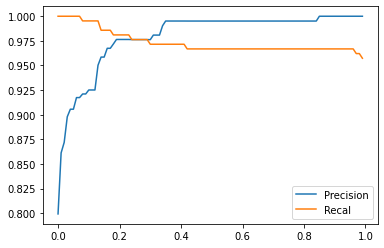

In [18]:
plt.plot(thresholds, p, label='Precision')
plt.plot(thresholds, r, label='Recal')
plt.legend()

### Question 4
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [19]:
def get_f1(p,r):
    f1 = []
    for i in range(len(p)):
        f = (1*p[i]*r[i]) / (p[i]+r[i])
        f1.append(f)
    return f1

In [20]:
f1 = get_f1(p,r)
f1[:10]

[0.44421052631578944,
 0.46271929824561403,
 0.4657836644591612,
 0.4730941704035875,
 0.47522522522522526,
 0.47522522522522526,
 0.47845804988662133,
 0.47845804988662133,
 0.4783599088838269,
 0.4783599088838269]

In [21]:
thresholds[f1.index(max(f1))].round(1)

0.4

### Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard devidation of the AUC scores across different folds?

In [22]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [23]:
def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [24]:
from sklearn.model_selection import KFold

In [25]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [26]:
scores

[0.9943244739756367,
 0.9944852941176471,
 0.9938076416337287,
 0.9997405293201868,
 1.0]

In [27]:
np.array(scores).std().round(3)

0.003

### Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]
Initialize KFold with the same parameters as previously
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

In [28]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.995 +- 0.004
C=0.1 0.997 +- 0.003
C=1 0.996 +- 0.003
C=10 0.997 +- 0.003
